In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import zipfile
import os

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/GTSRB_Final_Test_Images.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')


In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/GTSRB-Training_fixed.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

In [2]:
train_directory = "/content/drive/MyDrive/GTSRB/Training"
# Path to the CSV file containing the testing labels
ground_truth ="/content/drive/MyDrive/GT-final_test.csv"
# Path to the test image directory
test_directory = "/content/drive/MyDrive/GTSRB/Final_Test/Images"

In [3]:
import os
import glob
import cv2
import numpy as np
import pandas as pd

from PIL import Image
import shutil

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
image_paths = glob.glob(os.path.join(train_directory, '**', '*.ppm'), recursive=True)

images = []
labels = []

In [ ]:
print(image_paths)

['/content/drive/MyDrive/GTSRB/Training/00000/00000_00000.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00001.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00002.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00003.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00004.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00005.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00006.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00007.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00008.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00009.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00010.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00011.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00012.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00013.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_00014.ppm', '/content/drive/MyDrive/GTSRB/Training/00000/00000_000

In [ ]:
# Use the 'glob' module to find all image files in the subdirectories

for image_path in image_paths:

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to 32x32 pixels
    image = cv2.resize(image, (128, 128))
    # Normalize the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0
    images.append(image)

    # Extract the label from the image path
    label = int(image_path.split(os.sep)[-2])
    labels.append(label)

# Convert the lists to NumPy arrays for easier manipulation
images = np.array(images)
labels = np.array(labels)

print("Loaded", len(images), "images and", len(labels), "labels.")

Loaded 26640 images and 26640 labels.


In [ ]:
import pickle

# Save images and labels to Google Drive using pickle
with open('/content/drive/MyDrive/images.pkl', 'wb') as f:
    pickle.dump(images, f)

with open('/content/drive/MyDrive/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

print("Images and labels saved successfully.")


Images and labels saved successfully.


In [4]:
import pickle

# Load images and labels from Google Drive using pickle
with open('/content/drive/MyDrive/images.pkl', 'rb') as f:
    images1= pickle.load(f)

with open('/content/drive/MyDrive/labels.pkl', 'rb') as f:
    labels1 = pickle.load(f)

print("Images and labels loaded successfully.")
print(len(labels1))
print(len(images1))

Images and labels loaded successfully.
26640
26640


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Read the CSV file into a pandas DataFrame
ground_truth_df = pd.read_csv(ground_truth, delimiter=";")

# Print the loaded DataFrame
print(ground_truth_df.head())

    Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


In [6]:
# Get the list of test image file names
test_files = sorted(os.listdir(test_directory))

# Initialize an empty list to store the test images
test_images = []

# Iterate over the test files
for test_file in test_files:
    # Construct the full path to the test image
    image_path = os.path.join(test_directory, test_file)

    # Read the test image using OpenCV
    image = cv2.imread(image_path)


    # Check if the image is empty
    if image is None:
        print(f"Skipping file: {image_path}")
        continue

    # Resize the image to 32x32 pixels
    image = cv2.resize(image, (32, 32))

    # Normalize the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0

    # Append the image to the list of test images
    test_images.append(image)

# Convert the list of test images to a NumPy array
test_images = np.array(test_images)

print("Loaded", len(test_images), "test images.")

Skipping file: /content/drive/MyDrive/GTSRB/Final_Test/Images/GT-final_test.test.csv
Loaded 12630 test images.


In [7]:
# Extract the class IDs from the ground_truth_df DataFrame
class_ids = ground_truth_df['ClassId'].values

# Assign X_test as the test_images array
X_test = test_images

# Assign y_test as the class_ids array
y_test = class_ids

In [8]:
print("Training dataset:")
print("Images shape:", images1.shape)
print("Labels shape:", labels1.shape)
print("="*20)
print("Testing dataset:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training dataset:
Images shape: (26640, 32, 32, 3)
Labels shape: (26640,)
Testing dataset:
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


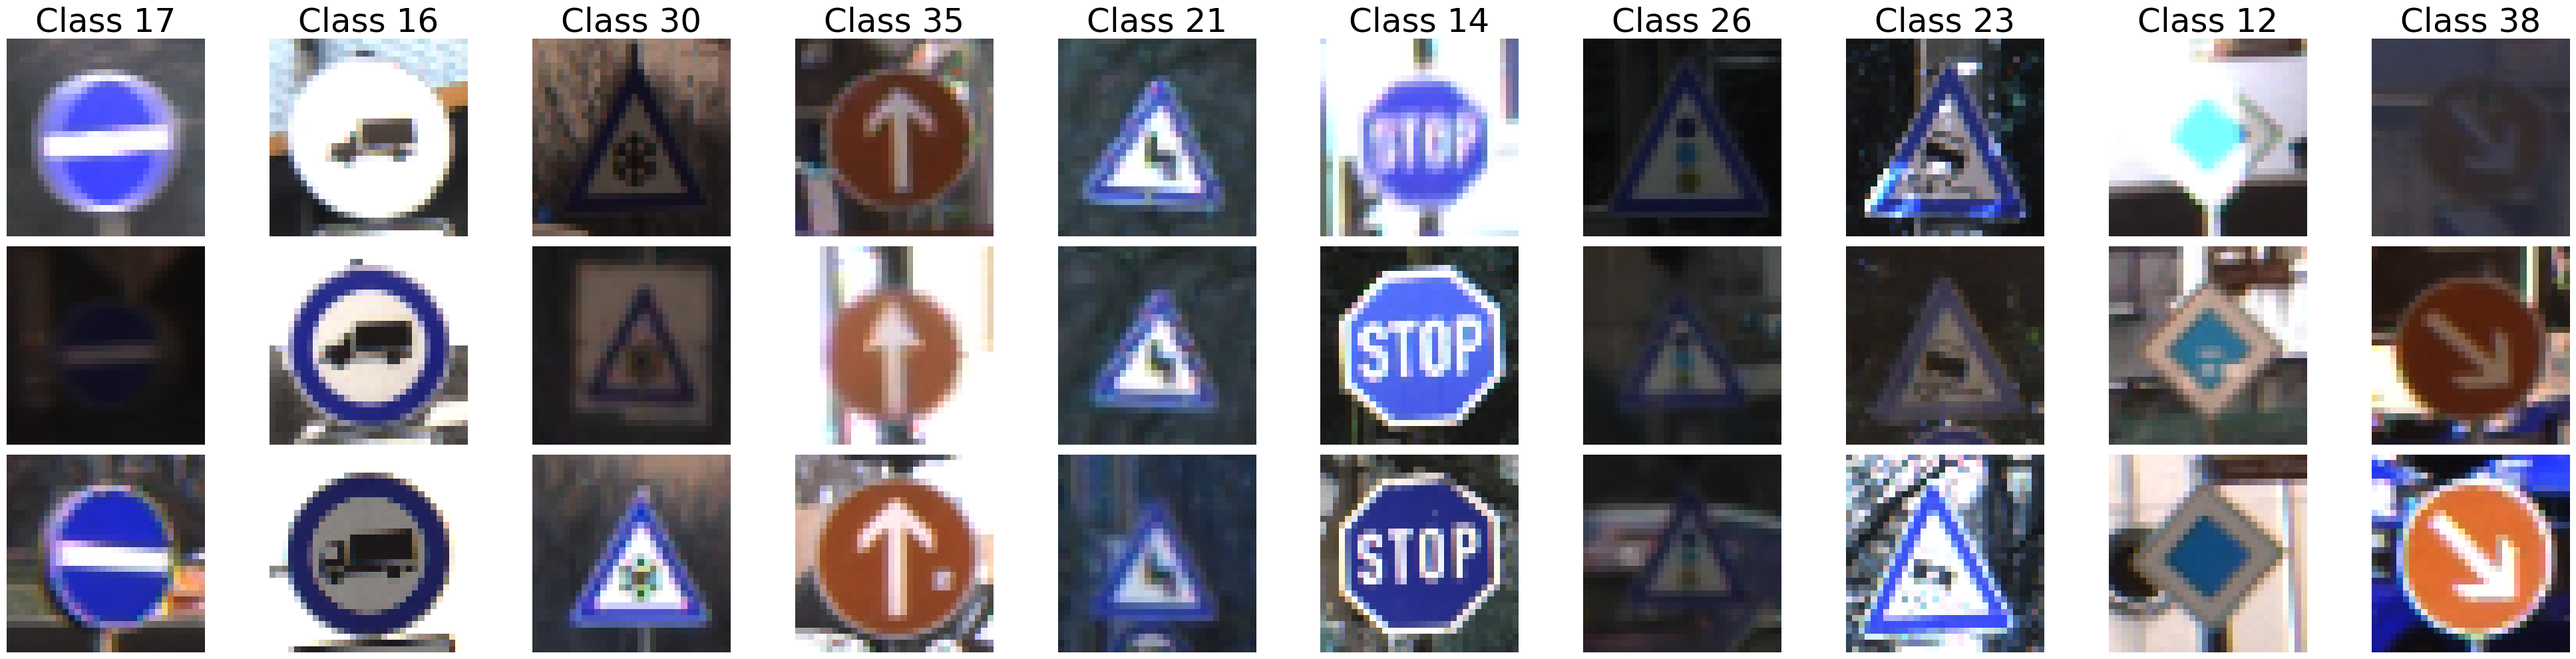

In [9]:
import random
import matplotlib.pyplot as plt

# Select 10 random class IDs from the training data
random_classes = random.sample(list(set(labels1)), k=10)

# Create a subplot grid for the images
fig, axes = plt.subplots(nrows=3, ncols=len(random_classes), figsize=(4 * len(random_classes), 10))

# Iterate over the random class IDs
for i, class_id in enumerate(random_classes):
    # Find the indices of images in the training data belonging to the current class
    class_indices = np.where(labels1 == class_id)[0]

    # Randomly select 3 image indices for display
    random_indices = random.sample(list(class_indices), k=3)

    # Display the class label at the top of the column
    axes[0, i].set_title(f"Class {class_id}", fontsize = 36)

    # Iterate over the random image indices
    for j, image_index in enumerate(random_indices):
        # Get the corresponding image
        image = images1[image_index]

        # Display the image
        axes[j, i].imshow(image)
        axes[j, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [10]:
num_classes=43

In [11]:
# Split the training dataset
X_train, X_val, y_train, y_val = train_test_split(images1, labels1)

In [12]:
print("Training dataset:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

Training dataset:
X_train shape: (19980, 32, 32, 3)
X_val shape: (6660, 32, 32, 3)
y_train shape: (19980,)
y_val shape: (6660,)


In [13]:

def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

    # Show the figu

In [14]:
base_model = ResNet50(include_top=False, input_shape=(32, 32, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint('ResNet50model_checkpoint.h5', save_best_only=True,verbose=1)
RestNet50_model=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
625/625 [==============================] - 31s 49ms/step - loss: 0.0105 - accuracy: 0.9979 - val_loss: 0.0313 - val_accuracy: 0.9935
Epoch 2/100
625/625 [==============================] - 30s 48ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.0403 - val_accuracy: 0.9920
Epoch 3/100
625/625 [==============================] - 32s 51ms/step - loss: 0.0269 - accuracy: 0.9969 - val_loss: 0.0513 - val_accuracy: 0.9916
Epoch 4/100
625/625 [==============================] - 30s 48ms/step - loss: 0.0451 - accuracy: 0.9913 - val_loss: 0.0482 - val_accuracy: 0.9901
Epoch 5/100
625/625 [==============================] - 29s 46ms/step - loss: 0.0123 - accuracy: 0.9976 - val_loss: 0.0244 - val_accuracy: 0.9949
Epoch 6/100
625/625 [==============================] - 29s 47ms/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 0.0550 - val_accuracy: 0.9913
Epoch 7/100
625/625 [==============================] - 31s 49ms/step - loss: 0.0142 - accuracy: 0.9973 - val_loss: 0.0314 - val_ac

In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

395/395 [==============================] - 5s 12ms/step - loss: 0.4495 - accuracy: 0.9314
Test Loss: 0.4495140314102173
Test Accuracy: 0.9313539266586304


In [24]:
#model.save('/content/resnet50_model.h5')
model.save('/content/drive/MyDrive/ResNet50_trained_model3.h5')


In [25]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the saved model
model = load_model('/content/drive/MyDrive/ResNet50_trained_model3.h5')

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/test2.jpeg'
input_image = Image.open(input_image_path)
input_image = input_image.resize((32, 32))  # Resize to match input shape
input_data = np.expand_dims(np.array(input_image), axis=0)
input_data = preprocess_input(input_data)

# Make predictions
predictions = model.predict(input_data)

# Assuming softmax activation is used for the output layer
predicted_class = np.argmax(predictions)

print("Predicted Class:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicted Class: 14


1/1 [==============================] - 1s 891ms/step


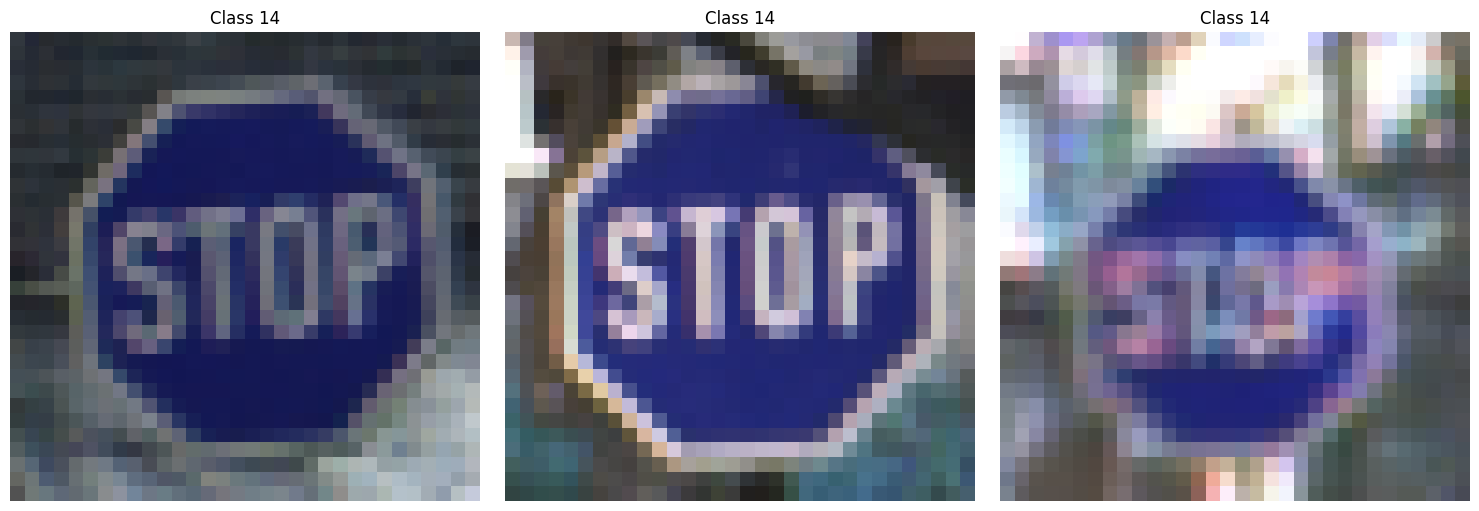

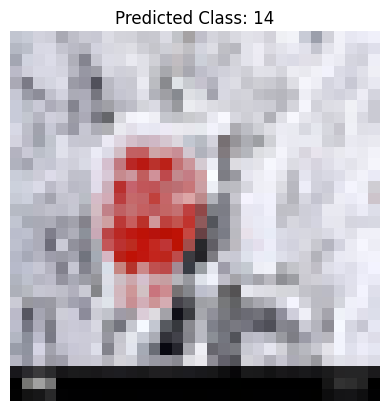

In [26]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/drive/MyDrive/ResNet50_trained_model3.h5')

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/test2.jpeg'
input_image = Image.open(input_image_path)
input_image = input_image.resize((32, 32))  # Resize to match input shape
input_data = np.expand_dims(np.array(input_image), axis=0)
input_data = preprocess_input(input_data)

# Make predictions
predictions = model.predict(input_data)

# Assuming softmax activation is used for the output layer
class_id_to_display = np.argmax(predictions)

import matplotlib.pyplot as plt

# Select the class ID for which you want to display images
# Change this to the desired class ID

# Find the indices of images in the training data belonging to the specified class
class_indices = np.where(labels1 == class_id_to_display)[0]

# Randomly select 3 image indices for display
random_indices = random.sample(list(class_indices), k=3)

# Create a subplot grid for the images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over the randomly selected image indices
for i, image_index in enumerate(random_indices):
    # Get the corresponding image
    image = images1[image_index]

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Class {class_id_to_display}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Plot the input image with the predicted class as title
plt.imshow(input_image)
plt.title(f"Predicted Class: {class_id_to_display}")
plt.axis('off')
plt.show()
